In [355]:
import math
import csv
from scipy import integrate
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from cardano_method import CubicEquation

In [356]:
pi = math.pi
accuracy = 1e-16
q = 1.602176634e-19 # elementary charge
m0 = 9.1093837015e-31 # electron mass
mRel = 0.31 # b-Ga2O3 relative reduced electron mass 
m = mRel * m0 # b-Ga2O3 reduced electron mass
h = 6.62607015e-34 # Planck constant
hBar = h/6/pi
kB = 1.380649e-23 # Boltzmann constant
e0 = 8.8541878128e-12 # vacuum permittivity
eOpt = 3.57 # optical dielectric constant of b-Ga2O3
eSta = 10 # static dielectric constant of b-Ga2O3
T = 295 # device temperature
kT = kB*T 
Nc = 1e-6*2*(2*pi*m*kT/h**2)**1.5
n = 1.45e18 # sample carrier concentration in cm-3
phiM = kT*np.log(Nc/n)/q # Ec-Ef in eV  
#phi = 1 # Barrier height in eV
A = 4*pi*q*m*kB**2/h**3 # effective Richarson constant in A/m2/K2
aOpt = q/16/pi/eOpt/e0 # coefficient a (with the negative sign, optic) in front of the 1/x term of the potential a = e/(16*pi*e)
aSta = q/16/pi/eSta/e0 # coefficient a (with the negative sign, static) in front of the 1/x term of the potential a = e/(16*pi*e)
b = 0
#b = q*n*1e6/2/e0/eSta # coefficient b (V/m2) in front of the quadratic term of the potential b = q*n/2e
print (kT/q)

0.025421133123328277


In [357]:
def fF (phiB, Vr): # surface electrical field in V/m
    return ((2*q*n*1e6*(phiB-Vr-phiM-kT/q)/eSta/e0)**0.5)
def fWd (phiB, Vr): # depletion width in nm
    return ((2/q/n/1e6*(phiB-Vr-phiM-kT/q)*eSta*e0)**0.5*1e9)
def fXmax(phiB, Vr, a): # position in nm, at which the top of the potential barrier reaches maximum  
    equation = CubicEquation([2*b*1e-18,-fF(phiB,Vr)*1e-9,0,a*1e9]) # coefficients are converted so that the solutions give results in nm
    return (equation.answers[2].real) # first solution is ~ Wd, second is ~ -xmax, and third is xmax
def fEmax(phiB, Vr, a): # top of the potential barrier in eV
    x = fXmax(phiB, Vr, a)*1e-9 # convert xmax back to m
    return (phiB - fF(phiB,Vr)*x - a/x + b*x**2)
def fX1X2(W, phiB, Vr, a): # returns an array with positions x1, x2 in nm, where W and E intersect 
    # W is in V, if it is energy it would be measusred in eV
    equation = CubicEquation([b*1e-18,-fF(phiB,Vr)*1e-9,phiB-W,-a*1e9])# coefficients are converted so that the solutions give results in nm
    return ([equation.answers[1].real, equation.answers[2].real])
    #return(equation.answers)
def fIntegrand(x, W, phiB, F, a, b): # returns function that needs to be integrated, unit is V^0.5
    # x is in nanometer, W, phiB in V, F in V/m, a V*m, b in V/m2
    y = x*1e-9
    return ((phiB-W-F*y-a/y+b*y**2)**0.5)
def fProb(W, phiB, Vr, a): # returns probability of the transition of electons with energy W (in eV in this case)
    x1,x2 = fX1X2(W,phiB,Vr, a)
    F = fF(phiB, Vr)
    if W >= fEmax(phiB, Vr, a):
        result = 1
    else:
        rIntegral = integrate.quad(fIntegrand, x1, x2, args = (W, phiB, F, a, b))[0]
        #print(f"rIntegral: ", rIntegral, " x1: ", x1, " x2: ", x2, " W: ", W)
        try:
            result = 1/(1 + np.exp((8*m*q)**0.5/hBar*rIntegral*1e-9))
        except OverflowError:
            result = 0
    return (result)
def fDiffJ(W, phiB, Vr, a): # returns differential current density in A/cm2/eV at energy W in eV (or V)
    if (np.exp(-W*q/kT) > accuracy):
        result = A*T/kB*fProb(W, phiB, Vr, a)*np.log(1 + np.exp(-W*q/kT))*1e-4*q
    else:
        result = A*T/kB*fProb(W, phiB, Vr, a)*np.exp(-W*q/kT)*1e-4*q
    return (result)
def fJ (phiB, Vr, a): # returns current in A/cm2
    result = integrate.quad(fDiffJ, 0, np.inf, args =(phiB, Vr, a))[0]
    return (result)

In [358]:
arrV = -np.linspace(1, 4000, 4001) # array of different in eV from the top of the potential
#arrF = [(fF(1.4, V)*1e-8) for V in arrV] # in MV/cm
#arrJ = [(fJ(1.4, V, aSta)) for V in arrV] # in A/cm2 
print(fJ(1.4, -200, aSta))

nan


/tmp/ipykernel_461/2554833055.py:26: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rIntegral = integrate.quad(fIntegrand, x1, x2, args = (W, phiB, F, a, b))[0]
/tmp/ipykernel_461/2554833055.py:40: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = integrate.quad(fDiffJ, 0, np.inf, args =(phiB, Vr, a))[0]


Text(0, 0.5, 'Current Density (A/cm2)')

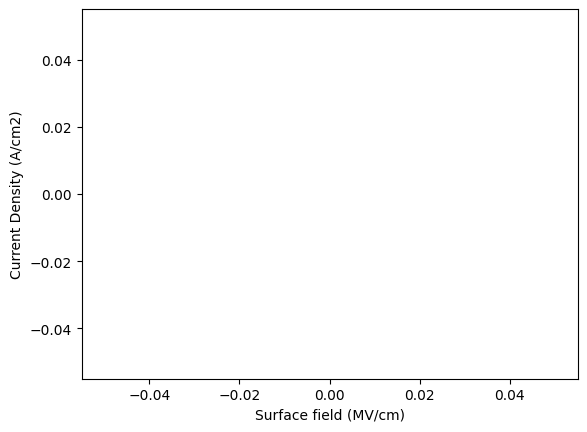

In [352]:
fig2, ax2 = plt.subplots()
ax2.plot(arrF, arrJ)
ax1.set_yscale('log')
plt.xlabel("Surface field (MV/cm)")
plt.ylabel("Current Density (A/cm2)")

In [342]:

with open("F01BH1p10OptDC.csv", "w", newline="") as csvfile:
  # Create a csv writer object
  writer = csv.writer(csvfile)
  # Combine data using zip and write as rows
  writer.writerows(zip(arrV, arrJ))

In [353]:
print(arrJ)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [175]:
# print (A*T/kB*1e-4*q) # in A/cm2/eV
# print (math.exp(-40))
# print (math.exp(-40)*A*T/kB*1e-4*q) # in A/cm2
# print (q/kT)
# print (fProb(1, 1, 0, aSta))
# print (np.exp(-q/kT))
a = np.exp(-37)
print ("a: ", a, " log: " , np.log(1 + a))

a:  8.533047625744066e-17  log:  0.0


In [191]:
arrDelW = np.linspace(0.001, 0.2, 200) # array of different in eV from the top of the potential
arrProb = [(fProb(fEmax(1,0,aSta)-delW,1,0, aSta)) for delW in arrDelW] 

rIntegral:  0.0289432740764565  x1:  1.780102  x2:  2.947825  W:  0.9674888818594846
rIntegral:  0.05823842094541573  x1:  1.60523  x2:  3.269974  W:  0.9664888818594846
rIntegral:  0.08788247835849637  x1:  1.483733  x2:  3.538841  W:  0.9654888818594846
rIntegral:  0.11787256770693602  x1:  1.389197  x2:  3.780839  W:  0.9644888818594846
rIntegral:  0.14820588940005777  x1:  1.311492  x2:  4.0061  W:  0.9634888818594846
rIntegral:  0.1788797198016316  x1:  1.245474  x2:  4.219767  W:  0.9624888818594846
rIntegral:  0.20989140914063378  x1:  1.188115  x2:  4.424867  W:  0.9614888818594846
rIntegral:  0.24123837736982112  x1:  1.137463  x2:  4.623354  W:  0.9604888818594846
rIntegral:  0.2729181113998836  x1:  1.092175  x2:  4.816571  W:  0.9594888818594846
rIntegral:  0.30492816464090217  x1:  1.051285  x2:  5.005484  W:  0.9584888818594846
rIntegral:  0.33726615104379887  x1:  1.014067  x2:  5.190818  W:  0.9574888818594846
rIntegral:  0.3699297425970929  x1:  0.979967  x2:  5.373129

Text(0, 0.5, 'Transmission Probability')

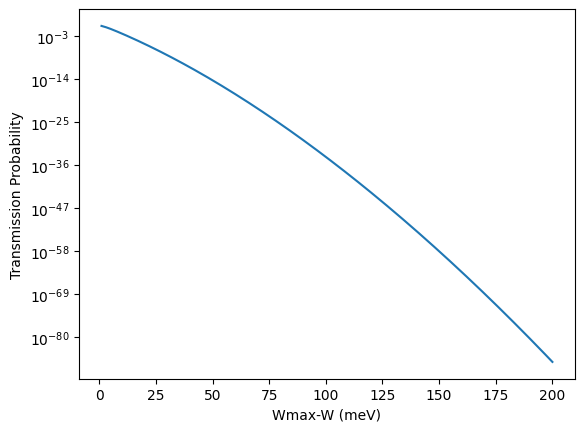

In [193]:
fig, ax = plt.subplots()
ax.plot(arrDelW*1e3, arrProb)
ax.set_yscale('log')
plt.xlabel("Wmax-W (meV)")
plt.ylabel("Transmission Probability")

In [264]:
arrW = np.linspace(0.001, 1, 1000)
arrDiffJ = [(fDiffJ(W, 1, -500, aSta)) for W in arrW]

rIntegral:  3.7506014423628455  x1:  0.036261  x2:  5.832958  W:  0.001
rIntegral:  3.744685428140436  x1:  0.036297  x2:  5.827043  W:  0.002
rIntegral:  3.738772359841777  x1:  0.036334  x2:  5.821128  W:  0.003
rIntegral:  3.73286216113267  x1:  0.036371  x2:  5.815213  W:  0.004
rIntegral:  3.726954861135379  x1:  0.036408  x2:  5.809298  W:  0.005
rIntegral:  3.7210504226372265  x1:  0.036445  x2:  5.803383  W:  0.006
rIntegral:  3.7151489416308636  x1:  0.036482  x2:  5.797468  W:  0.007
rIntegral:  3.7092503619078223  x1:  0.03652  x2:  5.791553  W:  0.008
rIntegral:  3.7033546718933823  x1:  0.036557  x2:  5.785638  W:  0.009000000000000001
rIntegral:  3.697461861049512  x1:  0.036594  x2:  5.779722  W:  0.010000000000000002
rIntegral:  3.6915720022017324  x1:  0.036632  x2:  5.773807  W:  0.011
rIntegral:  3.6856850093252684  x1:  0.036669  x2:  5.767891  W:  0.012
rIntegral:  3.6798009679076746  x1:  0.036707  x2:  5.761976  W:  0.013000000000000001
rIntegral:  3.673919813010

rIntegral:  1.4369370657968858  x1:  0.066085  x2:  3.199736  W:  0.444
rIntegral:  1.4324759708419184  x1:  0.066209  x2:  3.193737  W:  0.445
rIntegral:  1.428018661380079  x1:  0.066334  x2:  3.187737  W:  0.446
rIntegral:  1.423565153252459  x1:  0.066459  x2:  3.181736  W:  0.447
rIntegral:  1.4191154511034634  x1:  0.066584  x2:  3.175735  W:  0.448
rIntegral:  1.4146695451242333  x1:  0.06671  x2:  3.169734  W:  0.449
rIntegral:  1.4102274454782284  x1:  0.066837  x2:  3.163732  W:  0.45
rIntegral:  1.405789144387207  x1:  0.066964  x2:  3.157729  W:  0.451
rIntegral:  1.401354673112695  x1:  0.067091  x2:  3.151726  W:  0.452
rIntegral:  1.3969240058184573  x1:  0.067219  x2:  3.145723  W:  0.453
rIntegral:  1.3924971464043379  x1:  0.067348  x2:  3.139719  W:  0.454
rIntegral:  1.3880741182804865  x1:  0.067477  x2:  3.133715  W:  0.455
rIntegral:  1.3836549219734062  x1:  0.067606  x2:  3.12771  W:  0.456
rIntegral:  1.379239543719826  x1:  0.067736  x2:  3.121705  W:  0.457


Text(0, 0.5, 'Differential Current Density (A/cm2/eV)')

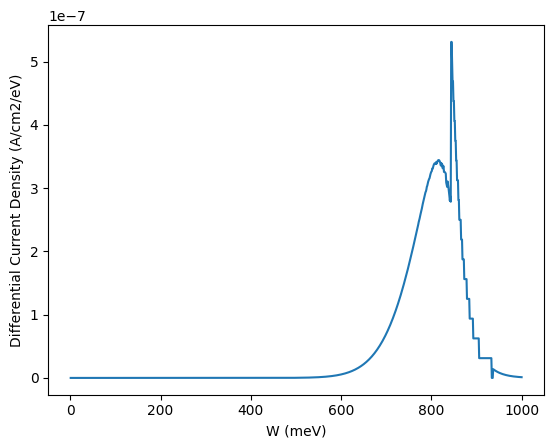

In [265]:
fig1, ax1 = plt.subplots()
ax1.plot(arrW*1e3, arrDiffJ)
ax1.set_yscale('linear')
plt.xlabel("W (meV)")
plt.ylabel("Differential Current Density (A/cm2/eV)")

In [204]:
#print (arrDiffJ)